In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

### Handy utility functions

In [2]:
def append_ones(matrix):
    return np.concatenate((matrix, np.ones((matrix.shape[0], 1), dtype=np.float32)), axis=1)

def zeros(*dims):
    return np.zeros(shape=tuple(dims), dtype=np.float32)

def ones(*dims):
    return np.ones(shape=tuple(dims), dtype=np.float32)

def rand(*dims):
    return np.random.rand(*dims).astype(np.float32)

def chunks(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def tiles(examples):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]
    
    space_between_tiles = 2
    img_matrix = np.empty(shape=(rows_count * (tile_height + space_between_tiles) - space_between_tiles,  
                                 cols_count * (tile_width + space_between_tiles) - space_between_tiles))
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            img_matrix[x_0:x_0 + tile_height, y_0:y_0 + tile_width] = examples[r, c]
    
    plt.matshow(img_matrix, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.show()

# MNIST dataset

In [3]:
pip install mnist


Looking in indexes: https://pip-is-disabled.jupyter.lab.ii.agh.edu.pl/
Note: you may need to restart the kernel to use updated packages.


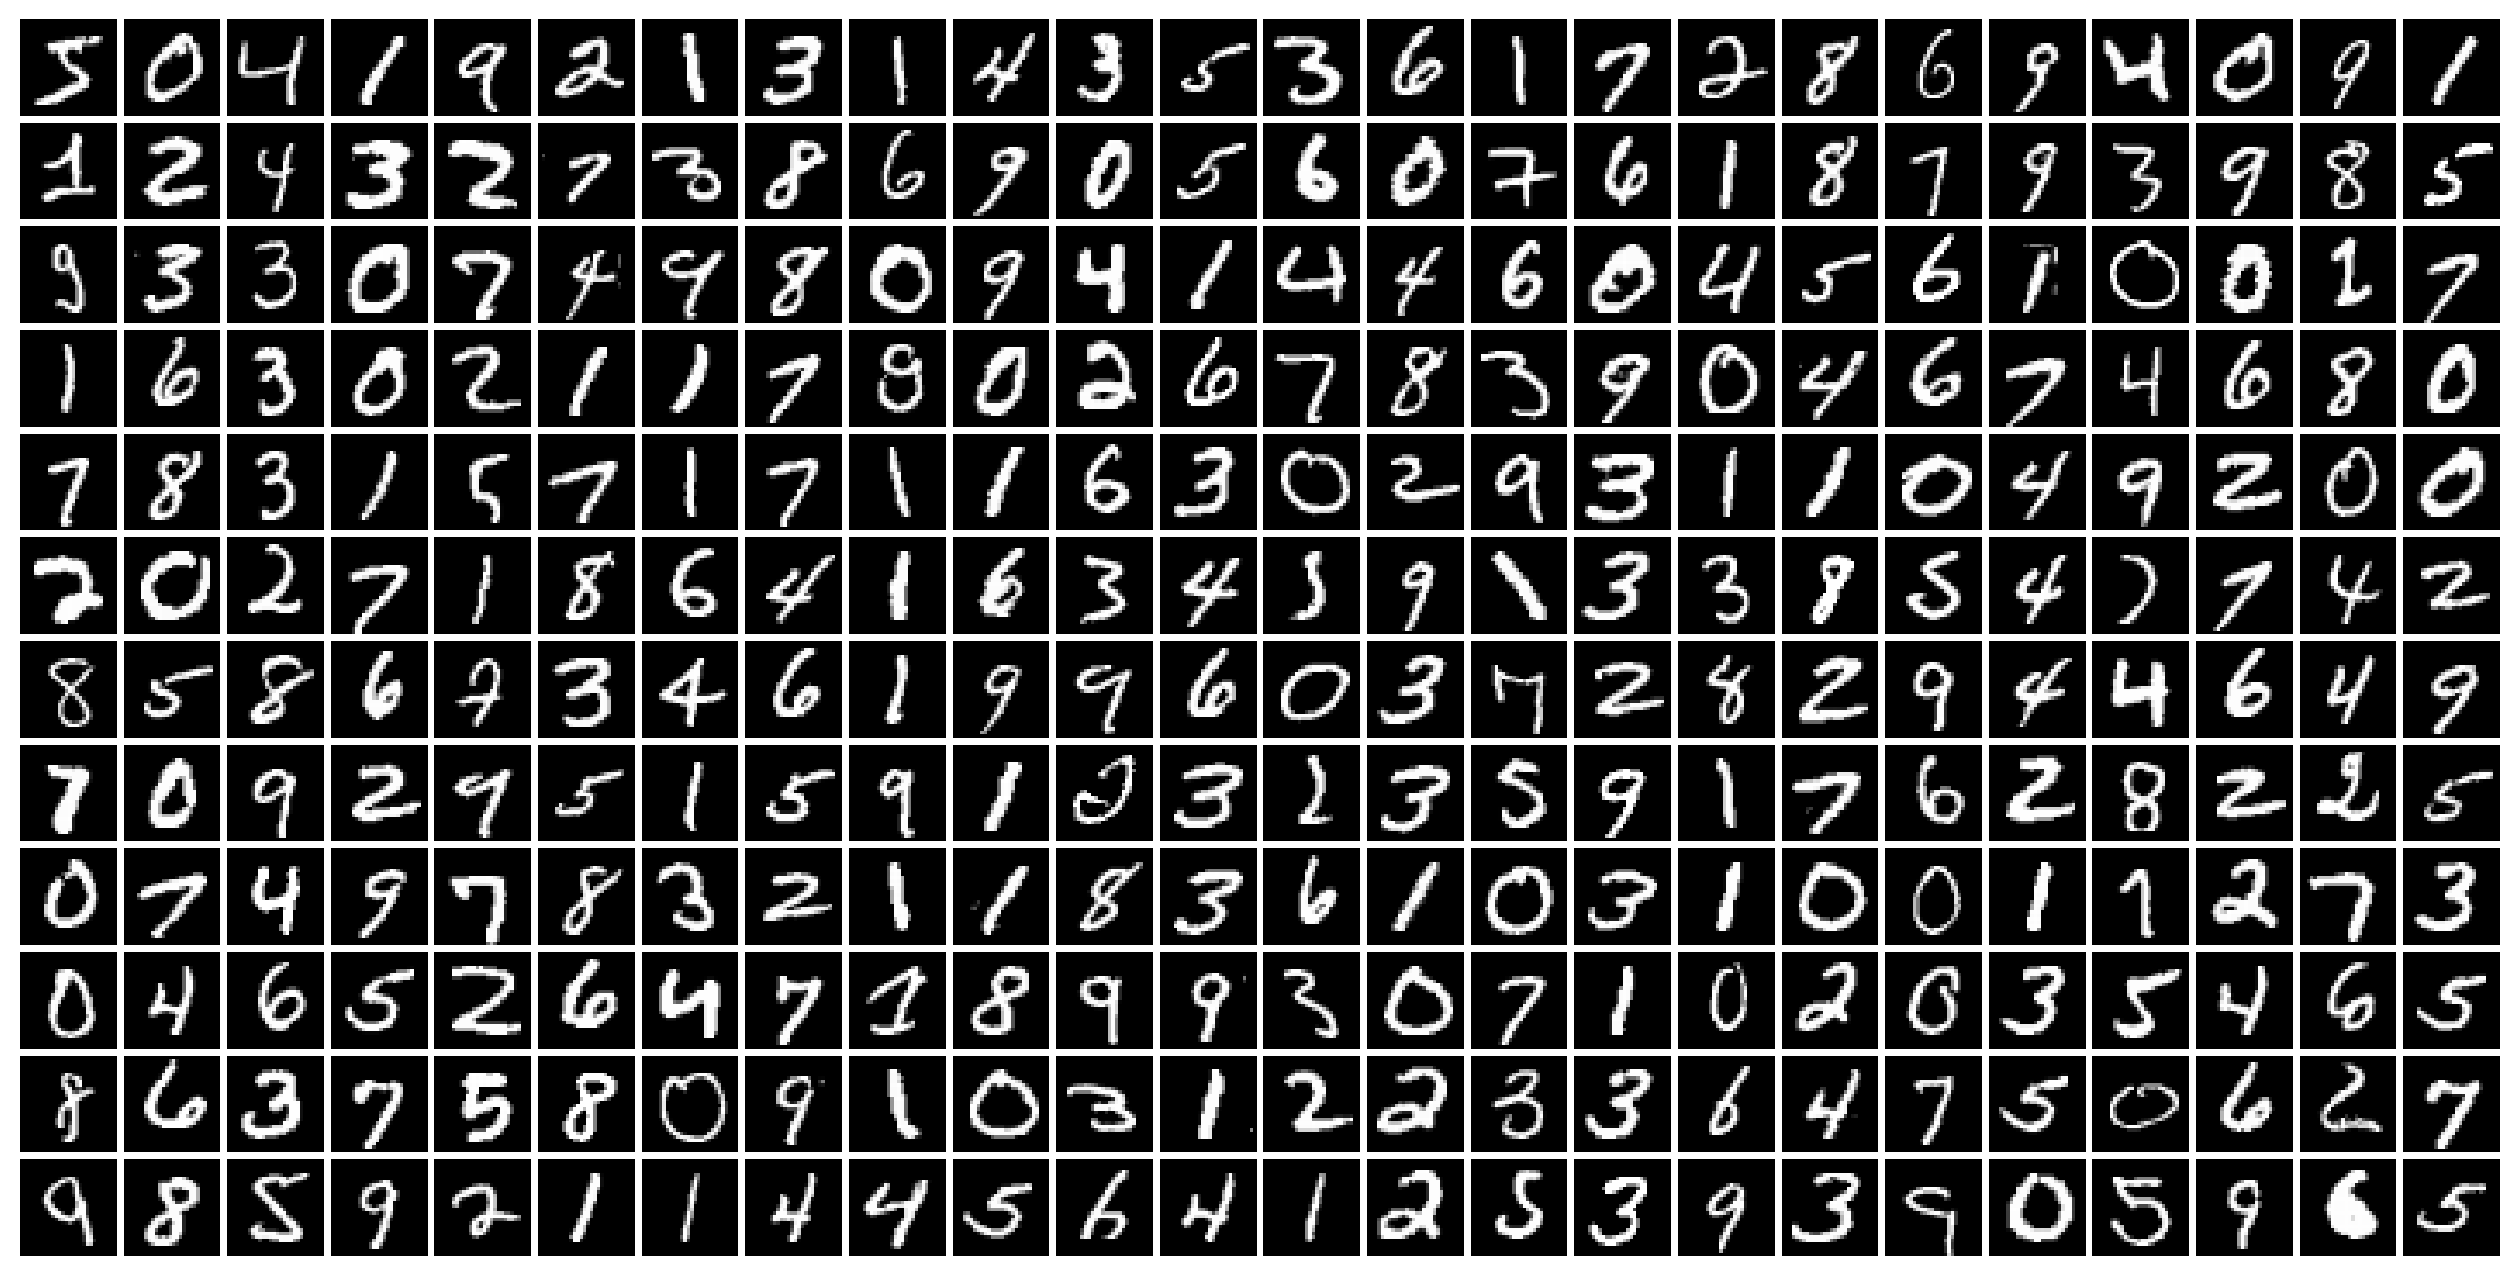

In [4]:
import mnist

mnist.datasets_url = 'https://storage.googleapis.com/cvdf-datasets/mnist/'

digits = np.reshape(mnist.train_images()[:12*24], newshape=(12, 24, 28, 28))
tiles(digits)

# Restricted Boltzmann Machine & Contrastive Divergence algorithm

In [5]:
def sigmoid(matrix):
    return 1.0 / (1.0 + np.exp(-matrix))

class Rbm:
    def __init__(self, visible_size, hidden_size, learning_rate):
        self.visible_size = visible_size
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        
        self.reset()
        
    def reset(self):
        self.W = np.random.normal(scale=0.01,
                                  size=(self.visible_size+1, self.hidden_size+1)).astype(np.float32)
        self.W[:, -1] = 0.0
        self.W[-1, :] = 0.0

## Algorytm Contrastive Divergence

$\newcommand{\vect}[1]{\mathbf{#1}}$
W sieci RBM gradient funkcji kosztu względem wag wyznaczamy zgodnie ze wzorem:

$\frac{\delta}{\delta w_{ij}} -\log P(\vect{v}) = -\mathbf{E}[v_i h_j \vert \vect{v}] + \mathbf{E}[v_i h_j]$

#### Faza pozytywna - odpowiada za część $\mathbf{E}[v_i h_j \vert \vect{v}]$

Tą część gradientu wyznaczamy przez wyliczenie iloczynów $v_i h_j$ pomiędzy elementami wektora obserwacji ($v_i$) a prawdopodobieństwami aktywacji w warstwie ukrytej ($h_j$). Operację tą możemy zapisać w postaci zwektoryzowanej jako:

$\nabla_P = \vect{v}^T\sigma(\vect{vW})$

#### Faza negatywna - odpowiada za część $\mathbf{E}[v_i h_j]$

Rozpoczynamy od prawdopodobieństw aktywacji neuronów w warstwie ukrytej, które zostały wyznaczone w fazie pozytywnej. Na ich podstawie losujemy próbkę aktywacji w warstwie ukrytej:

$\vect{h} = \sigma (\vect{vW}) > [rand_1, rand_2, \dots, rand_m]$

Następnie losujemy próbkę aktywacji w warstwie widocznej:

$\vect{v}_1 = \sigma (\vect{hW}^T) > [rand_1, rand_2, \dots, rand_n]$

Aby wyznaczyć *fantazję* sieci RBM, powyższe próbki losujemy (naprzemiennie) $k$ razy (gdzie $k$ to parametr algorytmu CD-*k*):

$\vect{h}_{k-1} = \sigma (\vect{v}_{k-1}\vect{W}) > [rand_1, rand_2, \dots, rand_m]$, 
$\vect{v}_k = \sigma (\vect{h}_{k-1}\vect{W}^T) > [rand_1, rand_2, \dots, rand_n]$

Część negatywną gradientu wyznaczamy poprzez wyliczenie iloczynów $v_{k_i} h_j$ pomiędzy elementami wektora *fantazji* RBM ($v_{k_i}$) a prawdopodobieństwami aktywacji w warstwie ukrytej wyliczonymi dla tejże *fantazji* ($h_j$). Operację tą możemy zapisać w postaci zwektoryzowanej jako:

$\nabla_N = \vect{v}_k^T\sigma(\vect{v}_k\vect{W})$


#### Aktualizacja macierzy wag RBM

Uczymy stochastycznym spadkiem wzdłuż gradientu:

$\phi_{t+1} \leftarrow \phi_t - \epsilon \nabla$

co dla gradientu RBM daje:

$W_{t+1} \leftarrow W_t + \epsilon \nabla_P - \epsilon \nabla_N$

In [6]:
def cdk(rbm, minibatch, k=1):
    observations_count = minibatch.shape[0]

    positive_visible = minibatch
    negative_visible = append_ones(zeros(observations_count, rbm.visible_size))

    positive_hidden = append_ones(zeros(observations_count, rbm.hidden_size))
    negative_hidden = append_ones(zeros(observations_count, rbm.hidden_size))

    positive_hidden[:, :-1] = sigmoid(positive_visible @ rbm.W[:, :-1])
    pos_grad = (positive_visible.T @ positive_hidden) / observations_count

    pos_h_rand_shape = positive_hidden.shape[0], positive_hidden.shape[1] - 1
    neg_h_rand_shape = negative_hidden.shape[0], negative_hidden.shape[1] - 1
    neg_v_rand_shape = negative_visible.shape[0], negative_visible.shape[1] - 1
    
    negative_hidden[:, :-1] = positive_hidden[:, :-1] > rand(*pos_h_rand_shape)
    
    negative_visible[:, :-1] = sigmoid(negative_hidden @ rbm.W[:-1, :].T) > rand(*neg_v_rand_shape)
    
    for _ in range(k - 1):
     
        negative_hidden[:, :-1] = sigmoid(negative_visible @ rbm.W[:, :-1]) > rand(*neg_h_rand_shape)
       
        negative_visible[:, :-1] = sigmoid(negative_hidden @ rbm.W[:-1, :].T) > rand(*neg_v_rand_shape)

    negative_hidden[:, :-1] = sigmoid(negative_visible @ rbm.W[:, :-1])
    neg_grad = (negative_visible.T @ negative_hidden) / observations_count
    
    rbm.W = rbm.W + rbm.learning_rate * pos_grad - rbm.learning_rate * neg_grad

### RBM reconstruction error

In [7]:
def reconstuction_error(rbm, minibatch):
    observations_count = minibatch.shape[0]
    visible = zeros(observations_count, rbm.visible_size)
    hidden = append_ones(zeros(observations_count, rbm.hidden_size))
    
    hidden[:, :-1] = sigmoid(minibatch @ rbm.W[:, :-1]) > rand(hidden.shape[0], hidden.shape[1] - 1)
    visible = sigmoid(hidden @ rbm.W[:-1, :].T)
    
    error = np.sum((minibatch[:, :-1] - visible) ** 2) / observations_count

    return error

# RBM Training

In [8]:
import time

DATASET_SIZE = 20000 
DIGIT_SIZE = 28

VISIBLE_LAYER_SIZE = DIGIT_SIZE*DIGIT_SIZE
HIDDEN_LAYER_SIZE = 128
LEARNING_RATE = 0.1

mnist_train = mnist.train_images().astype(np.float32) / 255.0
np.random.shuffle(mnist_train)
dataset = np.reshape(mnist_train[:DATASET_SIZE], newshape=(DATASET_SIZE, DIGIT_SIZE*DIGIT_SIZE))
dataset = append_ones(dataset)

monitoring_indeces = np.random.choice(DATASET_SIZE, 256, replace=False)
monitoring_set = dataset[monitoring_indeces]

rbm = Rbm(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, LEARNING_RATE)

In [9]:
def draw_filters(rbm):
    filters = np.reshape(np.transpose(rbm.W)[:-1, :-1], newshape=(8, -1, 28, 28))
    filters = np.clip(filters, -1, 1)
    tiles(filters)

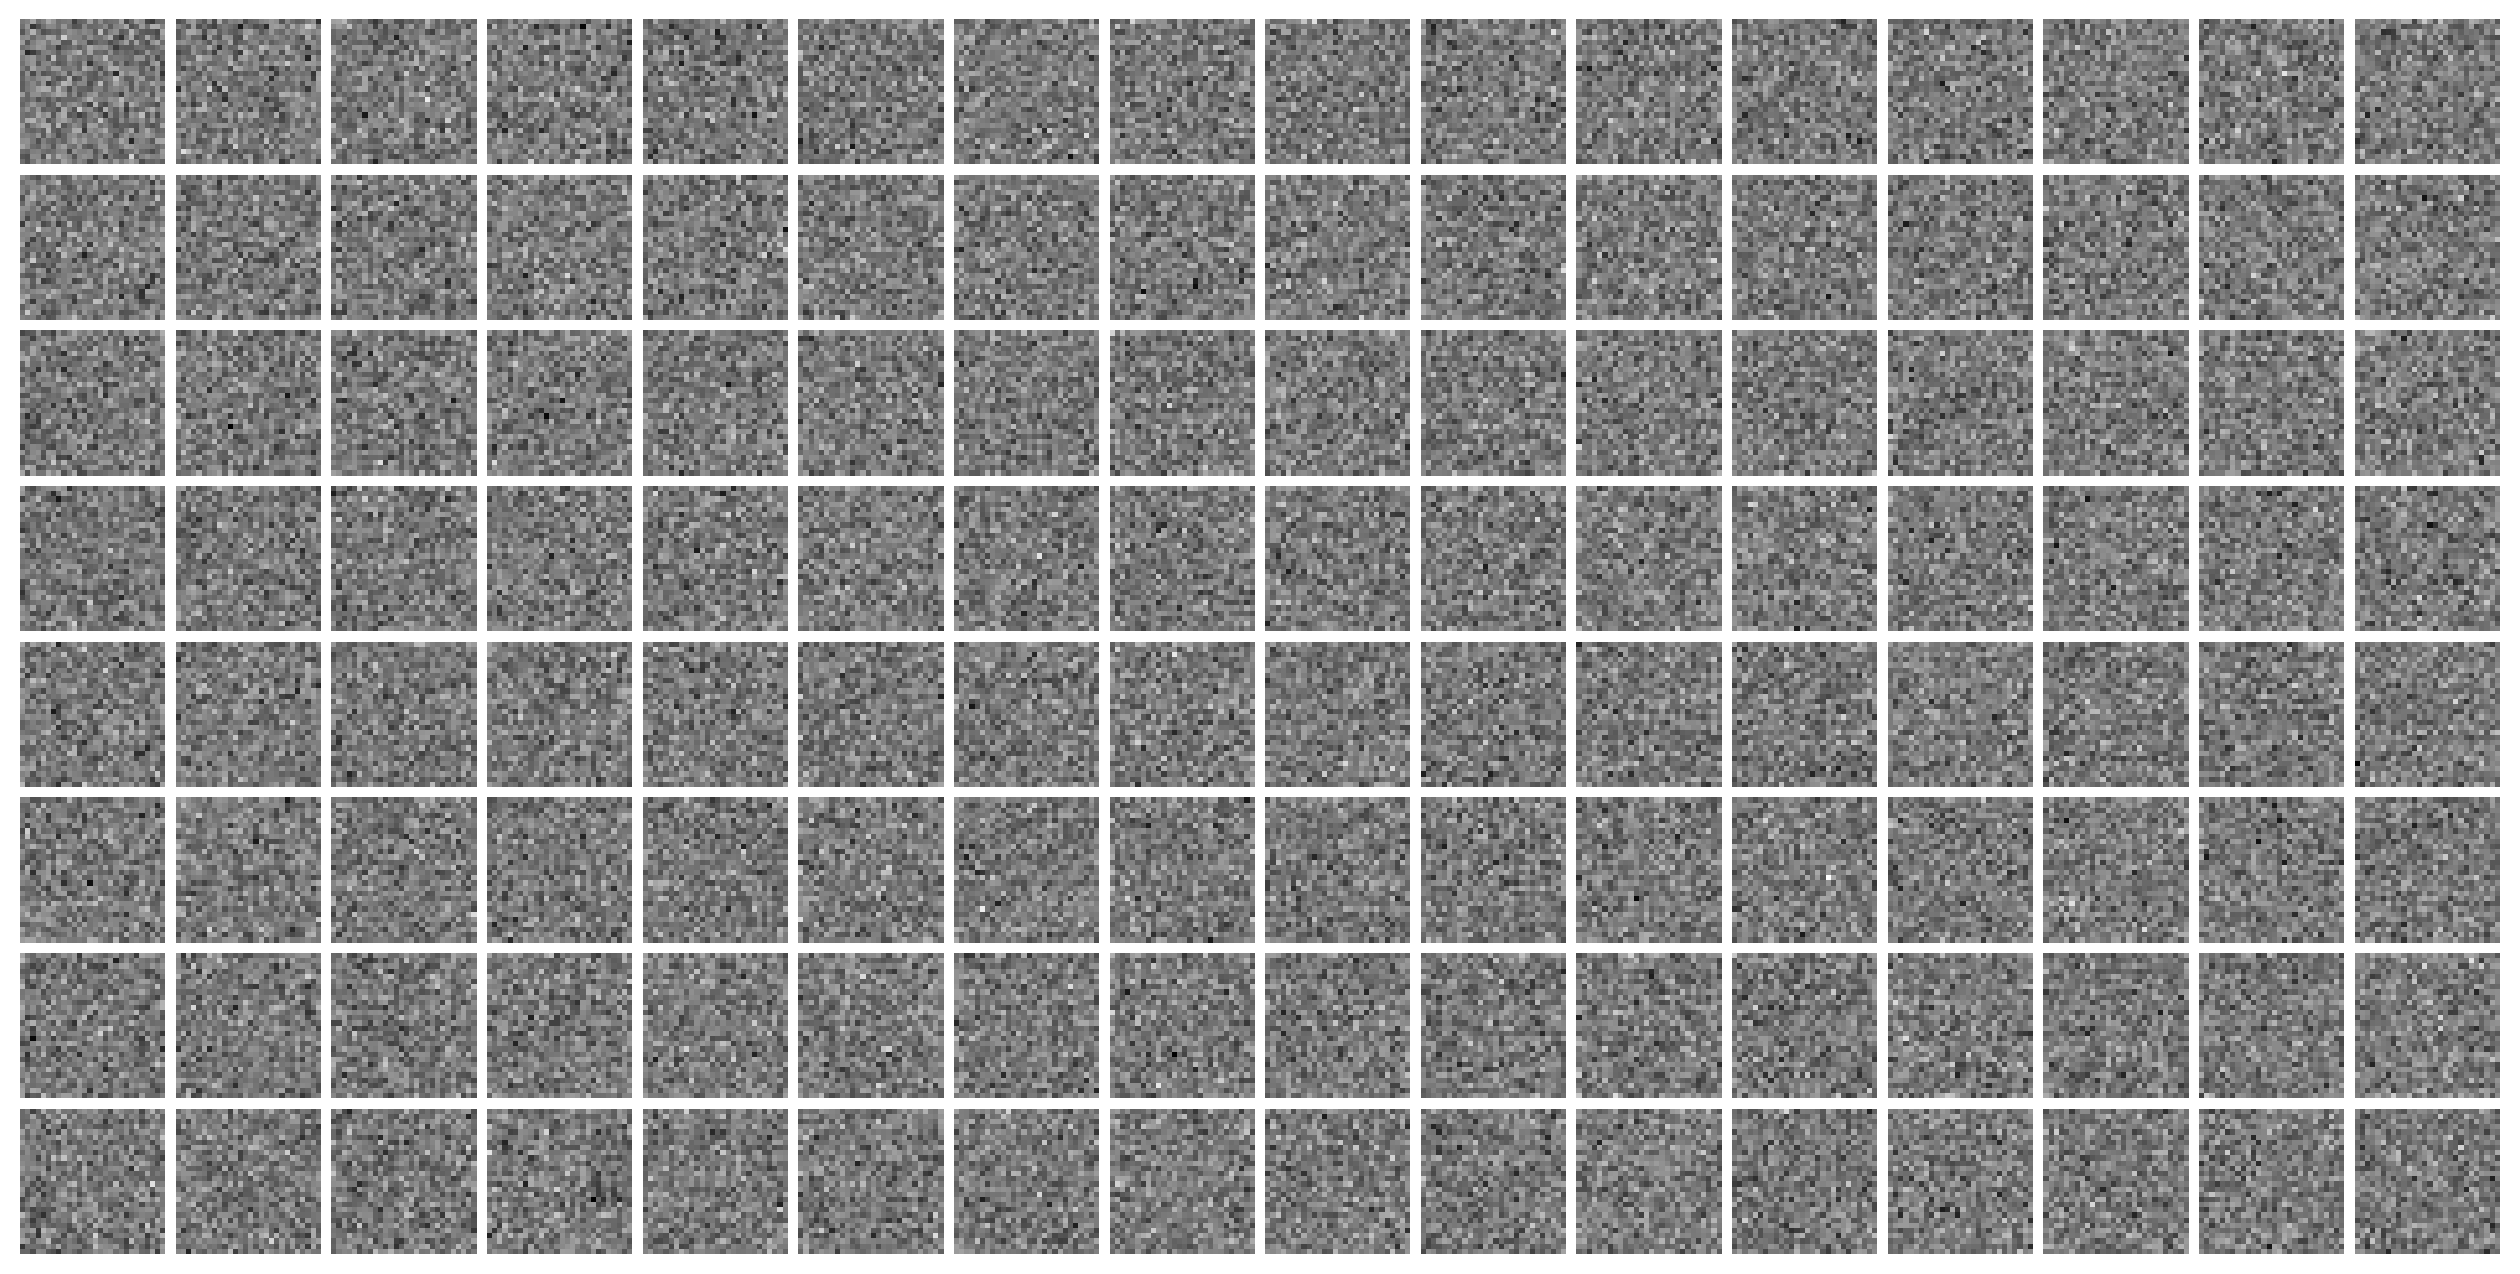

In [10]:
draw_filters(rbm)

In [12]:
BATCH_SIZE = 128
EPOCHS_COUNT = 50

def train_epoch(rbm, dataset):
    batches_limit = dataset.shape[0] / BATCH_SIZE
    for batch_idx, batch in enumerate(chunks(dataset, BATCH_SIZE)):
        cdk(rbm, batch)
        if batch_idx % round(batches_limit / 50) == 0: print("#", end="")

rbm.reset()
for epoch in range(EPOCHS_COUNT):
    print("Epoch {}:".format(epoch + 1),  end="\t")
    
    start_time = time.time()
    train_epoch(rbm, dataset)
    
    elapsed = time.time() - start_time
    error = reconstuction_error(rbm, monitoring_set)
    print("\n\telapsed: {0:>2.2f}s, reconstruction error: {1:>2.2f}".format(elapsed, error))
    
print("Training finished!")

Epoch 1:	#####################################################
	elapsed: 18.93s, reconstruction error: 32.38
Epoch 2:	#####################################################
	elapsed: 15.20s, reconstruction error: 26.22
Epoch 3:	#####################################################
	elapsed: 17.50s, reconstruction error: 22.82
Epoch 4:	#####################################################
	elapsed: 14.30s, reconstruction error: 20.99
Epoch 5:	#####################################################
	elapsed: 15.60s, reconstruction error: 19.43
Epoch 6:	#####################################################
	elapsed: 13.90s, reconstruction error: 18.47
Epoch 7:	#####################################################
	elapsed: 15.01s, reconstruction error: 17.63
Epoch 8:	#####################################################
	elapsed: 15.20s, reconstruction error: 17.05
Epoch 9:	#####################################################
	elapsed: 14.91s, reconstruction error: 16.41
Epoch 10:	#########

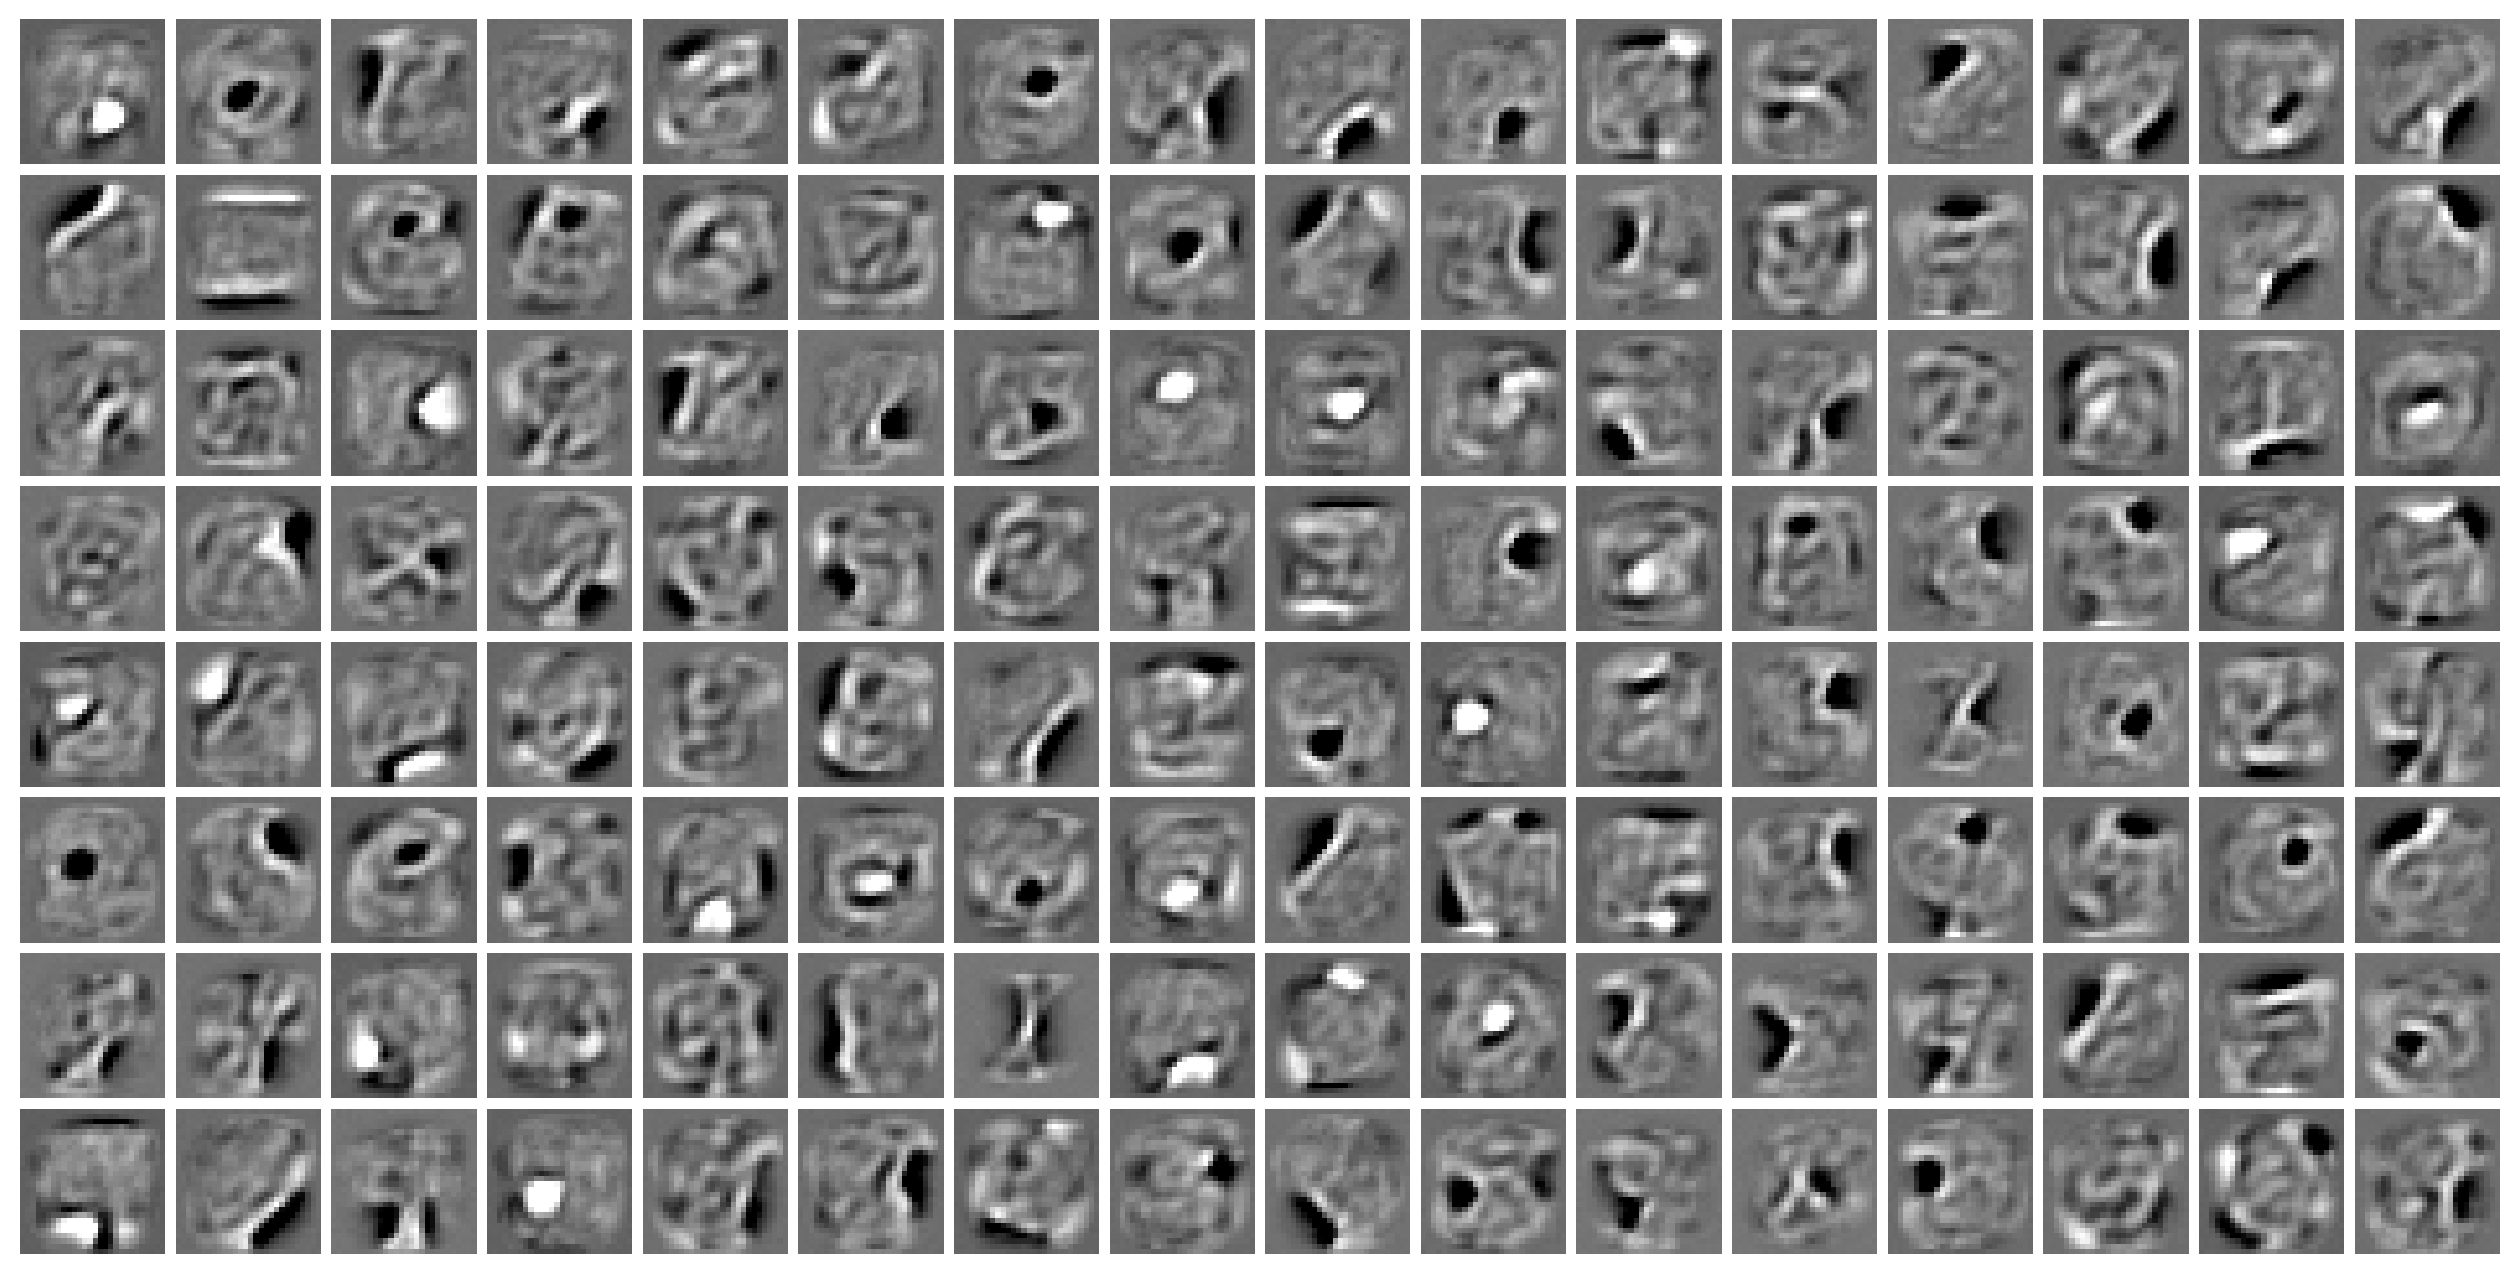

In [13]:
draw_filters(rbm)